### 머신러닝 기본 설정

In [75]:
# 기본적인 패키지부터 추가
import numpy as np
import pandas as pd
import scipy as super

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
from matplotlib import rc
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')
sns.set(font='Malgun Gothic', rc={'axes.unicode_minus':False}, style='darkgrid')

In [79]:
# ARIMA 모델 패키지
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [81]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [80]:
!pip install pmdarima

In [82]:
oil_price = pd.read_csv('./data/유가전처리.csv', encoding='utf-8', sep=',')
oil_price.head()

,일자,원유,휘발유,경유
0,2022-02-14,697.6,1681.6,1513.2
1,2022-02-15,685.0,1686.4,1517.1
2,2022-02-16,689.4,1692.5,1522.9
3,2022-02-17,683.3,1697.0,1529.0
4,2022-02-18,683.6,1699.5,1532.2


#### 시계열 예측 ARIMA

In [83]:
oil_price['일자'] = pd.to_datetime(oil_price['일자'], format='%Y-%m-%d')

In [84]:
gasolin_price = oil_price[['일자', '휘발유']]
gasolin_price

,일자,휘발유
0,2022-02-14,1681.6
1,2022-02-15,1686.4
2,2022-02-16,1692.5
3,2022-02-17,1697.0
4,2022-02-18,1699.5
...,...,...
172,2022-08-05,1831.1
173,2022-08-06,1825.3
174,2022-08-07,1823.2
175,2022-08-08,1813.1


In [85]:
gasolin_price.set_index('일자', inplace=True)
gasolin_price

,휘발유
일자,
2022-02-14,1681.6
2022-02-15,1686.4
2022-02-16,1692.5
2022-02-17,1697.0
2022-02-18,1699.5
...,...
2022-08-05,1831.1
2022-08-06,1825.3
2022-08-07,1823.2


In [86]:
gasolin_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2022-02-14 to 2022-08-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   휘발유     177 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


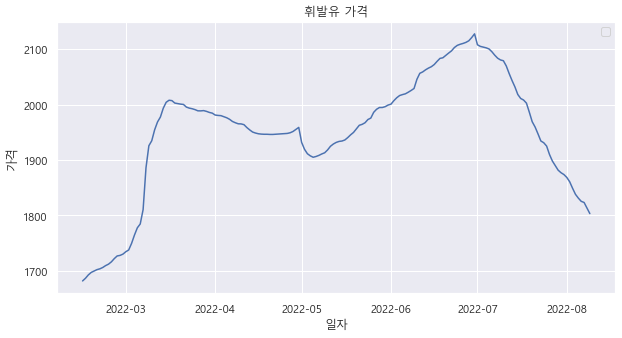

In [87]:
plt.figure(figsize=(10,5))
plt.plot(gasolin_price)
plt.xlabel('일자')
plt.ylabel('가격')
plt.title('휘발유 가격')
plt.legend()
plt.show()

In [88]:
gasolin_price.index[-1]

Timestamp('2022-08-09 00:00:00')

In [89]:
# 9일 값 예측 날짜 인덱스 df 만들기
index_9_days = pd.date_range(gasolin_price.index[-1], freq='D', periods=9, tz=None)
index_9_days

DatetimeIndex(['2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16',
               '2022-08-17'],
              dtype='datetime64[ns]', freq='D')

In [90]:
cur_oil_price = pd.read_csv('./data/과거_판매가격(주유소)20220810-20220817.csv', encoding='cp949')
cur_oil_price.head()

,번호,지역,상호,주소,기간,상표,셀프여부,고급휘발유,휘발유,경유,실내등유
0,기준 : 일간(20220810~20220817),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0033158,부산 강서구,(주)DJS신항만물류단지주유소,부산 강서구 가락대로 834 (범방동),20220810.0,S-OIL,셀프,0.0,1778.0,1878.0,0.0
2,A0033158,부산 강서구,(주)DJS신항만물류단지주유소,부산 강서구 가락대로 834 (범방동),20220811.0,S-OIL,셀프,0.0,1778.0,1878.0,0.0
3,A0033158,부산 강서구,(주)DJS신항만물류단지주유소,부산 강서구 가락대로 834 (범방동),20220812.0,S-OIL,셀프,0.0,1778.0,1878.0,0.0
4,A0033158,부산 강서구,(주)DJS신항만물류단지주유소,부산 강서구 가락대로 834 (범방동),20220813.0,S-OIL,셀프,0.0,1758.0,1858.0,0.0


In [91]:
cur_oil_price['기간'] = pd.to_datetime(cur_oil_price['기간'], format='%Y%m%d')
cur_oil_price.rename(columns={'기간' : '일자'}, inplace=True)
cur_oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   번호      3063 non-null   object        
 1   지역      3062 non-null   object        
 2   상호      3062 non-null   object        
 3   주소      3062 non-null   object        
 4   일자      3062 non-null   datetime64[ns]
 5   상표      3062 non-null   object        
 6   셀프여부    3062 non-null   object        
 7   고급휘발유   3062 non-null   float64       
 8   휘발유     3062 non-null   float64       
 9   경유      3062 non-null   float64       
 10  실내등유    3062 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 263.4+ KB


In [106]:
cur1_oil_price = cur_oil_price.groupby(["일자"])['휘발유'].mean().round().to_frame()
cur1_oil_price = cur1_oil_price.rename(columns={'휘발유':'실제 휘발유값'})
cur1_oil_price

,실제 휘발유값
일자,
2022-08-10,1788.0
2022-08-11,1777.0
2022-08-12,1770.0
2022-08-13,1762.0
2022-08-14,1760.0
2022-08-15,1755.0
2022-08-16,1749.0
2022-08-17,1739.0


<AxesSubplot:title={'center':'휘발유가격 예측'}, xlabel='일자', ylabel='휘발유'>

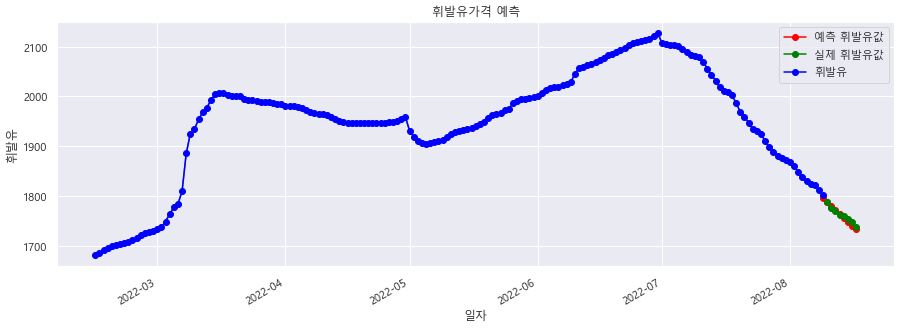

In [107]:
# Auto-ARIMA 돌리기 - 계측값이 일별이면 m=1, 월별이면 m=12, 주별이면 m=52, 
# 계절성이 있는 데이터면 seasonal=True 로 바꿔야함. 알아서 d 값을 찾아줌.
auto_arima_model = pm.auto_arima(gasolin_price, seasonal=False, m=1)

# 모델 예측
fcast2 = auto_arima_model.predict(9) 
fcast2 = pd.Series(fcast2, index=index_9_days)
fcast2 = fcast2.rename("예측 휘발유값")

# 예측값 시각화
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='일자', y='휘발유', data = gasolin_price)
chart.set_title('휘발유가격 예측')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
cur1_oil_price.plot(ax=ax, color='green', marker="o", legend=True)
gasolin_price.plot(ax=ax, color='blue', marker="o", legend=True)

In [108]:
prd1_oil_price = pd.DataFrame(fcast2)
prd1_oil_price

,예측 휘발유값
2022-08-09,1795.719734
2022-08-10,1787.932412
2022-08-11,1780.145090
2022-08-12,1772.357769
2022-08-13,1764.570447
2022-08-14,1756.783126
2022-08-15,1748.995804
2022-08-16,1741.208482
2022-08-17,1733.421161


In [109]:
pd.merge(cur1_oil_price, prd1_oil_price, how='inner', left_index=True, right_index=True)

,실제 휘발유값,예측 휘발유값
2022-08-10,1788.0,1787.932412
2022-08-11,1777.0,1780.145090
2022-08-12,1770.0,1772.357769
2022-08-13,1762.0,1764.570447
2022-08-14,1760.0,1756.783126
2022-08-15,1755.0,1748.995804
2022-08-16,1749.0,1741.208482
2022-08-17,1739.0,1733.421161


In [96]:
disel_price = oil_price[['일자', '경유']]
disel_price

,일자,경유
0,2022-02-14,1513.2
1,2022-02-15,1517.1
2,2022-02-16,1522.9
3,2022-02-17,1529.0
4,2022-02-18,1532.2
...,...,...
172,2022-08-05,1923.1
173,2022-08-06,1917.6
174,2022-08-07,1915.7
175,2022-08-08,1905.8


In [97]:
disel_price.set_index('일자', inplace=True)
disel_price

,경유
일자,
2022-02-14,1513.2
2022-02-15,1517.1
2022-02-16,1522.9
2022-02-17,1529.0
2022-02-18,1532.2
...,...
2022-08-05,1923.1
2022-08-06,1917.6
2022-08-07,1915.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


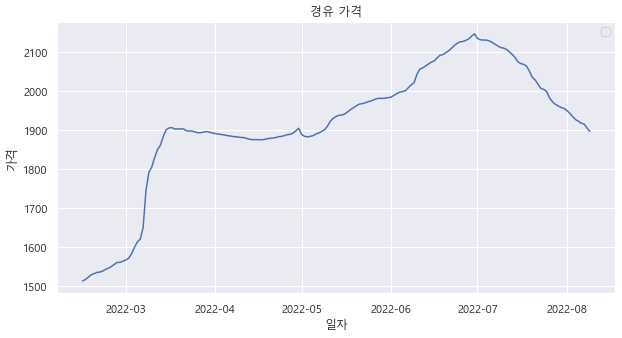

In [98]:
plt.figure(figsize=(10,5))
plt.plot(disel_price)
plt.xlabel('일자')
plt.ylabel('가격')
plt.title('경유 가격')
plt.legend()
plt.show()

In [99]:
disel_price.index[-1]

Timestamp('2022-08-09 00:00:00')

In [100]:
# 9일 값 예측 날짜 인덱스 df 만들기
index_9_days = pd.date_range(disel_price.index[-1], freq='D', periods=9, tz=None)
index_9_days

DatetimeIndex(['2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16',
               '2022-08-17'],
              dtype='datetime64[ns]', freq='D')

In [104]:
cur2_oil_price = cur_oil_price.groupby(["일자"])['경유'].mean().round().to_frame()
cur2_oil_price = cur2_oil_price.rename(columns={'경유' : '실제 경유값'})
cur2_oil_price

,실제 경유값
일자,
2022-08-10,1887.0
2022-08-11,1878.0
2022-08-12,1870.0
2022-08-13,1865.0
2022-08-14,1862.0
2022-08-15,1858.0
2022-08-16,1852.0
2022-08-17,1841.0


<AxesSubplot:title={'center':'경유가격 예측'}, xlabel='일자', ylabel='경유'>

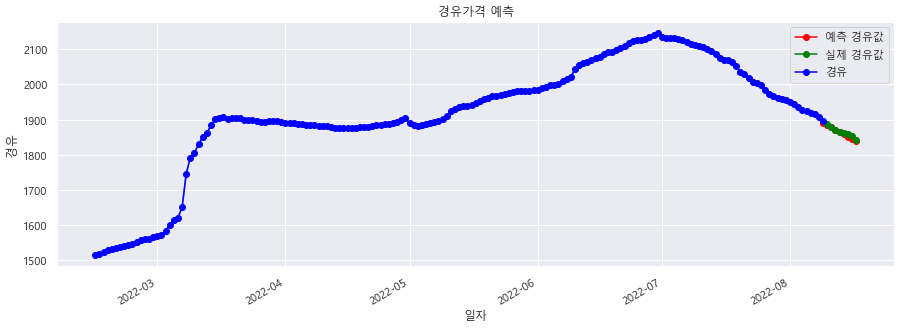

In [105]:
# Auto-ARIMA 돌리기 - 계측값이 일별이면 m=1, 월별이면 m=12, 주별이면 m=52, 
# 계절성이 있는 데이터면 seasonal=True 로 바꿔야함. 알아서 d 값을 찾아줌.
from cProfile import label


auto_arima_model = pm.auto_arima(disel_price, seasonal=False, m=1)

# 모델 예측
fcast2 = auto_arima_model.predict(9) 
fcast2 = pd.Series(fcast2, index=index_9_days)
fcast2 = fcast2.rename('예측 경유값')

# 예측값 시각화
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='일자', y='경유', data = disel_price)
chart.set_title('경유가격 예측')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
cur2_oil_price.plot(ax=ax, color='green', marker="o", legend=True)
disel_price.plot(ax=ax, color='blue', marker="o", legend=True)

In [ ]:
prd2_oil_price = pd.DataFrame(fcast2)
prd2_oil_price

,경유 예측값
2022-08-09,1890.832321
2022-08-10,1884.207087
2022-08-11,1877.581853
2022-08-12,1870.956620
2022-08-13,1864.331386
2022-08-14,1857.706152
2022-08-15,1851.080919
2022-08-16,1844.455685
2022-08-17,1837.830452


In [ ]:
pd.merge(cur2_oil_price, prd2_oil_price, how='inner', left_index=True, right_index=True)

,경유,경유 예측값
2022-08-10,1887.0,1884.207087
2022-08-11,1878.0,1877.581853
2022-08-12,1870.0,1870.956620
2022-08-13,1865.0,1864.331386
2022-08-14,1862.0,1857.706152
2022-08-15,1858.0,1851.080919
2022-08-16,1852.0,1844.455685
2022-08-17,1841.0,1837.830452
